<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#-Комментарий-ревьюера--" data-toc-modified-id="-Комментарий-ревьюера---3"><span class="toc-item-num">3&nbsp;&nbsp;</span> Комментарий ревьюера <a rel="nofollow"> </a></a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns 
import matplotlib.pyplot as plt 
from pylab import rcParams

from tqdm import tqdm


from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


import warnings
warnings.filterwarnings('ignore')

In [2]:
try:
    df = pd.read_csv('./taxi.csv')
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv')
    
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


<div style='background-color: #f2f2f2; padding: 10px; border: 3px solid #ccc; border-radius: 10px;'>
    <p><strong>Заметка:</strong>   <br>
        Данные не содержат пропусков 
    </p>
</div>

In [3]:
df.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [4]:
df['datetime'] = df['datetime'].astype('datetime64') 
df.set_index('datetime', inplace=True)

## Анализ

In [5]:
def exponential_smoothing(data, alpha):
    es = [data[0]]
    for t in range(1, len(data)):
        es.append(alpha * data[t] + (1 - alpha) * es[t - 1])
        return es

In [6]:
df.sort_index(inplace=True)

In [7]:
df.index.is_monotonic

True

<div style='background-color: #f2f2f2; padding: 10px; border: 3px solid #ccc; border-radius: 10px;'>
    <p><strong>Промежуточный вывод:</strong>   <br>
    Ряд является монотонным
    </p>
</div>

In [8]:
min(df.index), max(df.index)

(Timestamp('2018-03-01 00:00:00'), Timestamp('2018-08-31 23:50:00'))

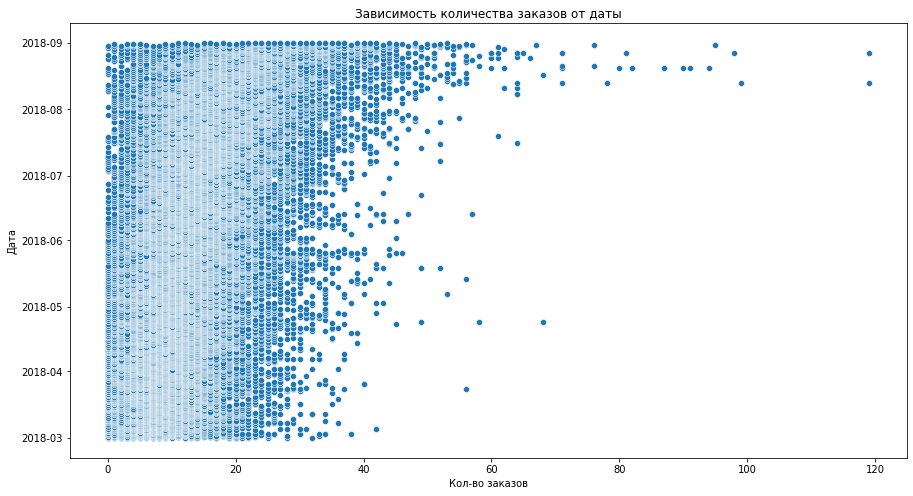

In [9]:
plt.figure(figsize = (15,8))
sns.scatterplot(df['num_orders'], df.index)
plt.title("Зависимость количества заказов от даты")
plt.xlabel("Кол-во заказов")
plt.ylabel("Дата")
plt.show()

<div style='background-color: #f2f2f2; padding: 10px; border: 3px solid #ccc; border-radius: 10px;'>
    <p><strong>Вывод по графику:</strong>   <br>
    Видно, что есть зависимость, что в течение года интервал кол-ва заказов увеличивался.
    </p>
</div>

In [10]:
df.iloc[1:3, 0]

datetime
2018-03-01 00:10:00    14
2018-03-01 00:20:00    28
Name: num_orders, dtype: int64

In [11]:
result = kpss(df['num_orders'], regression='ct')# установим ct чтобы задать 0 гипотезу о том что ряд стационарный по ттренду

print('KPSS:', result[0])
print('p-value:', result[1])
print('Лаги:', result[2])
print('CV:', result[3])

KPSS: 1.4964821452349168
p-value: 0.01
Лаги: 78
CV: {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}


In [12]:
#Применение теста ADF 
result = adfuller(df['num_orders'], regression='ct')

print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Лаги:', result[2])
print('Observations:', result[3])
print('CV:', result[4])

ADF Statistic: -22.035374434893427
p-value: 0.0
Лаги: 42
Observations: 26453
CV: {'1%': -3.9591122740276123, '5%': -3.410655982748717, '10%': -3.127147748777392}


<div style='background-color: #f2f2f2; padding: 10px; border: 3px solid #ccc; border-radius: 10px;'>
    <p><strong>Вывод по тестам:</strong>   <br><br>
       Были проведены два теста на стационарность - KPSS и ADF.<br>
        KPSS p-value: 0.01<br>
        ADF p-value: 0.0<br>
       Противоречия не получено.<br>
       Мы отвергаем что 0 гипотеза верна (ряд стационарный по тренду) по обоим тестам.<br>
    </p>
</div>

In [13]:
sum(df.loc['2018-03-01':'2018-04-01', 'num_orders'])/len(df.loc['2018-03-01':'2018-04-01', 'num_orders'])

9.552083333333334

In [14]:
sum(df.loc['2018-08-01':'2018-09-01','num_orders']) / len(df.loc['2018-08-01':'2018-09-01','num_orders'])

21.275313620071685

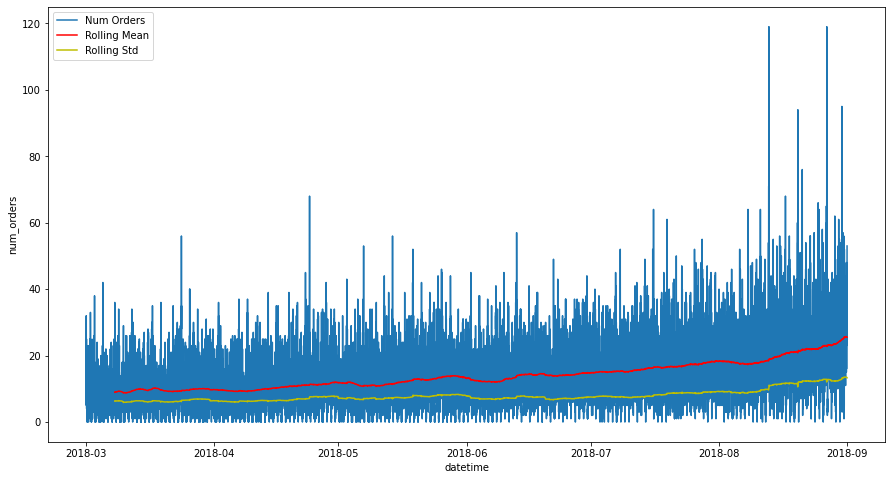

In [15]:
batch_size = 1000
rolling_mean = df['num_orders'].rolling(batch_size).mean()
rolling_std = df['num_orders'].rolling(batch_size).std()

plt.figure(figsize=(15,8))
sns.lineplot(x=df.index, y='num_orders', data=df)
sns.lineplot(x=df.index, y=rolling_mean, color='red')
sns.lineplot(x=df.index, y=rolling_std, color='y')
plt.legend(labels=['Num Orders', 'Rolling Mean', 'Rolling Std'])
plt.show()


<div style='background-color: #f2f2f2; padding: 10px; border: 3px solid #ccc; border-radius: 10px;'>
    <p><strong>Вывод по графику:</strong>   <br><br>
Среднее имеет тренд к повышению <br>
Стандартное отклонение так же имеет тренд к повышению   <br>
    </p>
</div>

<div style='background-color: #f2f2f2; padding: 10px; border: 3px solid #ccc; border-radius: 10px;'>
    <p><strong>Вывод :</strong>   <br><br>
Ряд не является стационарным   
    </p>
</div>

In [16]:
df = df.resample('1H').sum()
df 

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


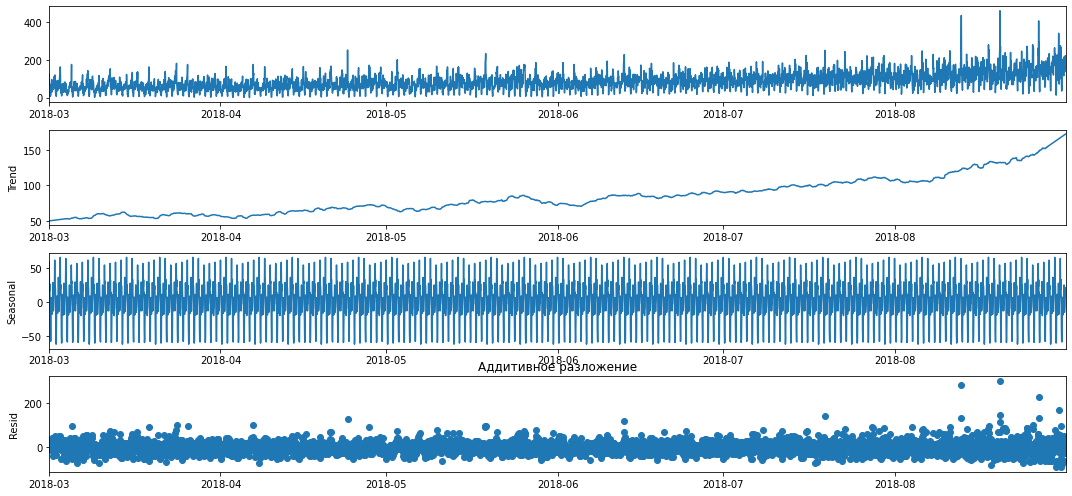

In [17]:
decomposed_add = seasonal_decompose(df, model='additive',extrapolate_trend=True, period=((24*60)//10))
rcParams['figure.figsize'] = 15, 7
decomposed_add.plot()
plt.title('Аддитивное разложение')

plt.show()

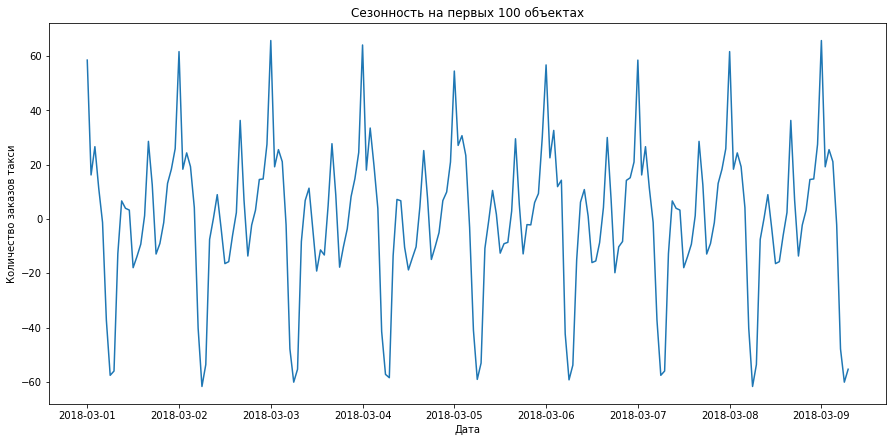

In [18]:
plt.title("Сезонность на первых 100 объектах")
sns.lineplot(y = decomposed_add.seasonal[:200], x =decomposed_add.seasonal[:200].index )
plt.ylabel('Количество заказов такси')
plt.xlabel("Дата")
plt.show()

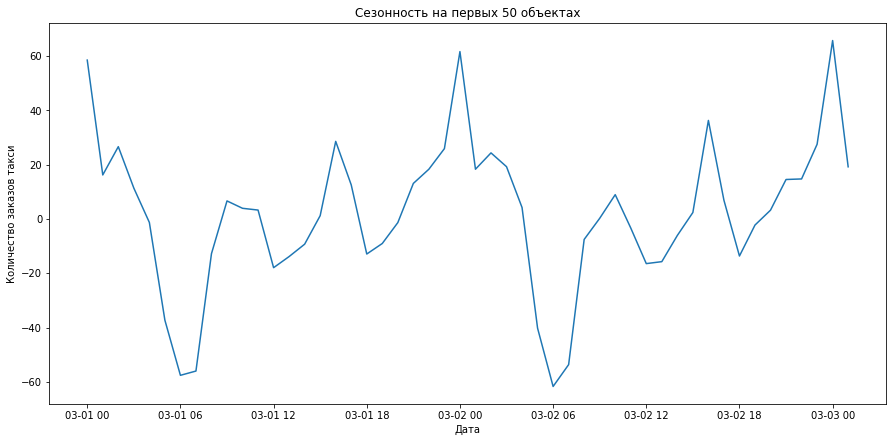

In [19]:
plt.title("Сезонность на первых 50 объектах")
sns.lineplot(y = decomposed_add.seasonal[:50], x =decomposed_add.seasonal[:50].index )
plt.ylabel('Количество заказов такси')
plt.xlabel("Дата")
plt.show()

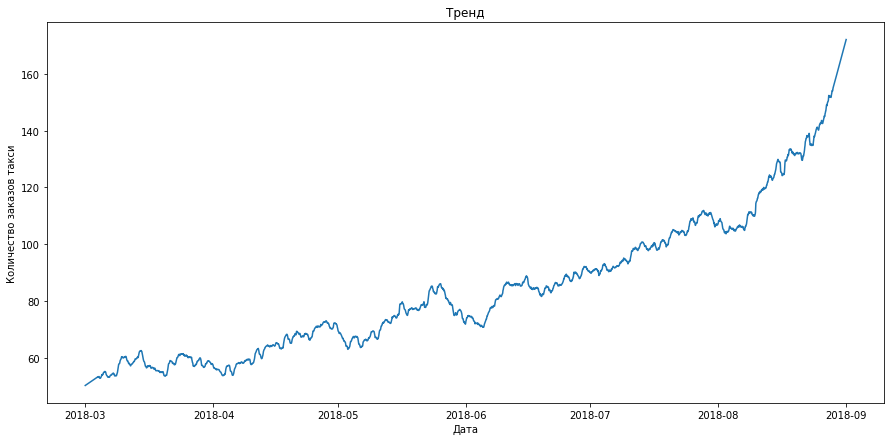

In [20]:
plt.title("Тренд")

sns.lineplot(y = decomposed_add.trend[:], x =decomposed_add.trend[:].index )
plt.ylabel('Количество заказов такси')
plt.xlabel("Дата")
plt.show()

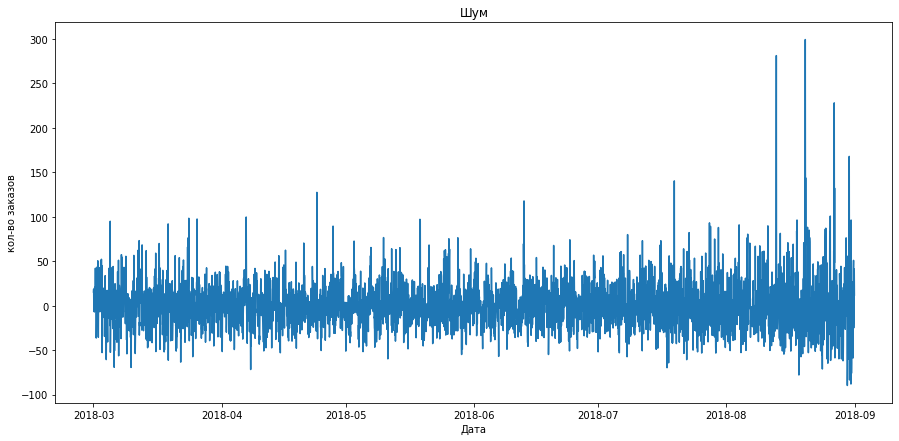

In [21]:
plt.title("Шум")

sns.lineplot(y = decomposed_add.resid[:], x =decomposed_add.resid[:].index ) 
plt.ylabel('кол-во заказов')
plt.xlabel("Дата")
plt.show()

<div style='background-color: #f2f2f2; padding: 10px; border: 3px solid #ccc; border-radius: 10px;'>
    <p><strong>Промежуточный вывод:</strong>   <br>
• на протяжении всего ряда наблюдается рост, что может указывать на увеличение спроса на услуги такси. <br>
• Амплитуда сезонных колебаний изменяется от -60 до 60 заказов такси.<br>
• В начале периода сезонности значения сезонности могут быть выше среднего уровня, что может объясняться увеличением спроса на услуги такси в начале рабочей недели или в выходные дни.<br>
• В середине периода сезонности значения сезонности снижаются и могут быть ниже среднего уровня, что может объясняться уменьшением спроса на услуги такси в середине рабочей недели.<br>
• В конце периода сезонности значения сезонности снова повышаются и могут быть выше среднего уровня, что может объясняться увеличением спроса на услуги такси в конце рабочей недели или перед выходными днями.<br>
    </p>
</div>

## Обучение

In [22]:
def add_features(data): 
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['hour'] = data.index.hour
    data['is_weekend'] = data.index.weekday.map(lambda x: 1 if x >= 5 else 0)
    data['is_rush_hour_var1']=data.index.hour.map(lambda x: 1 if (x>=5 and x<=9) or (x>=12 and x<=14) or (x>=18 and x<=21)   else 0)
    data['is_rush_hour_var2']=data.index.hour.map(lambda x: 1 if (x>=5 and x<=9) or (x>=18 and x<=21)   else 0)
    data['is_rush_hour_var3']=data.index.hour.map(lambda x: 1 if (x>=5 and x<=9) else 0)

    for i in range(24):
        data[f'value_lag{i+1}'] = data['num_orders'].shift(i+1)
    data.dropna(axis=0, inplace=True)
    
    window_size = 5
    data['rolling_mean'] = data['value_lag1'].rolling(window=window_size).mean()
    data['expanding_mean'] = data['value_lag1'].expanding().mean()

    data.dropna(axis=0, inplace=True)

    
    return data


In [23]:
score = {'LGBM': [np.nan, np.nan],'Random Forest':[np.nan, np.nan], 'Simple Exp Smoothing' : [np.nan, np.nan]}
df_score = pd.DataFrame(score, index=['best_score_validation', 'score_test'])
df_score

,LGBM,Random Forest,Simple Exp Smoothing
best_score_validation,NaN,NaN,NaN
score_test,NaN,NaN,NaN


In [24]:
#baseline 
train, test = df.iloc[0:int(0.9*len(df)),0], df.iloc[int(0.9*len(df)):len(df),0]
train_val, validation = train.iloc[0:int(0.9*len(train))], train.iloc[int(0.9*len(train)):len(train)]
(train.shape,test.shape), (train_val.shape, validation.shape)

(((3974,), (442,)), ((3576,), (398,)))

In [25]:
lgb_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'n_estimators':[i for i in range(140,151,10)], 
    'learning_rate': [i/100 for i in range(8,10)],  
    'lambda_l2' : [i/10 for i in range(2,3)],
    'min_sum_hessian_in_leaf' : 5
}
rf_params = {
    'n_estimators': [115],               
    'max_features': ['sqrt'],                   
    'max_depth': [10,11,12],                
    'min_samples_split': [10],               
    'min_samples_leaf': [4],                  
    'bootstrap': [True],                    
    'random_state': [42],                          
    'n_jobs': [-1]                                  
}

In [26]:
train_val = pd.DataFrame(train_val)
validation = pd.DataFrame(validation)

df_to_concat = pd.concat([train_val,validation], axis=0)
df_to_concat = add_features(df_to_concat)

train_val, validation = df_to_concat.iloc[0:int(0.9*len(df_to_concat)),:], df_to_concat.iloc[int(0.9*len(df_to_concat)):len(df_to_concat),:]

features = train_val.drop('num_orders',axis=1).columns
target = 'num_orders'

In [27]:
best_score = 10**8
for n_estimators in tqdm(lgb_params['n_estimators']):
    for learning_rate in lgb_params['learning_rate']:
        for lambda_l2 in lgb_params['lambda_l2']:
            
            lgb_model = lgb.LGBMRegressor(n_estimators=n_estimators, 
                                          learning_rate=learning_rate, 
                                          lambda_l2=lambda_l2,
                                          min_sum_hessian_in_leaf = 5,
                                          objective = 'regression',
                                          metric = 'rmse', njobs=-1)

            lgb_model.fit(train_val[features], 
              train_val[target].values, 
              verbose=10) 
            
            pr =  lgb_model.predict(validation[features])
            score = mean_squared_error(validation[target], pr, squared=False)
            
            if score < best_score:
                best_score_lgb = score
                best_model_lgb = lgb_model
                best_preds_lgb = pr
            
                df_score['LGBM']['best_score_validation'] = best_score_lgb
                
                
best_score = 10**8
for n_estimators in tqdm(rf_params['n_estimators']):
    for max_features in rf_params['max_features']:
        for max_depth in rf_params['max_depth']:
            for min_samples_split in rf_params['min_samples_split']:
                for min_samples_leaf in rf_params['min_samples_leaf']:
                    for bootstrap in rf_params['bootstrap']:
            
                        rf_model = RandomForestRegressor(
                                          n_estimators=n_estimators, 
                                          max_features=max_features, 
                                          max_depth=max_depth,

                                          min_samples_split = min_samples_split, 
                                          min_samples_leaf = min_samples_leaf,
                                          bootstrap = bootstrap,
                                          random_state = 42,
                                          n_jobs = -1)

                        rf_model.fit(train_val[features], 
                                     train_val[target].values
                                     ) 

                        pr =  rf_model.predict(validation[features])
                        score = mean_squared_error(validation[target], pr, squared=False)

                        if score < best_score:
                            best_score = score
                            best_model = rf_model
                            best_preds = pr
                            df_score['Random Forest']['best_score_validation'] = best_score



  0%|          | 0/2 [00:00<?, ?it/s]

[LightGBM] [Warning] Unknown parameter: njobs
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=5, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=5
[LightGBM] [Warning] lambda_l2 is set=0.2, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2
[LightGBM] [Warning] Unknown parameter: njobs
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=5, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=5
[LightGBM] [Warning] lambda_l2 is set=0.2, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2


 50%|█████     | 1/2 [00:03<00:03,  3.66s/it]

[LightGBM] [Warning] Unknown parameter: njobs
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=5, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=5
[LightGBM] [Warning] lambda_l2 is set=0.2, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2
[LightGBM] [Warning] Unknown parameter: njobs
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=5, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=5
[LightGBM] [Warning] lambda_l2 is set=0.2, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


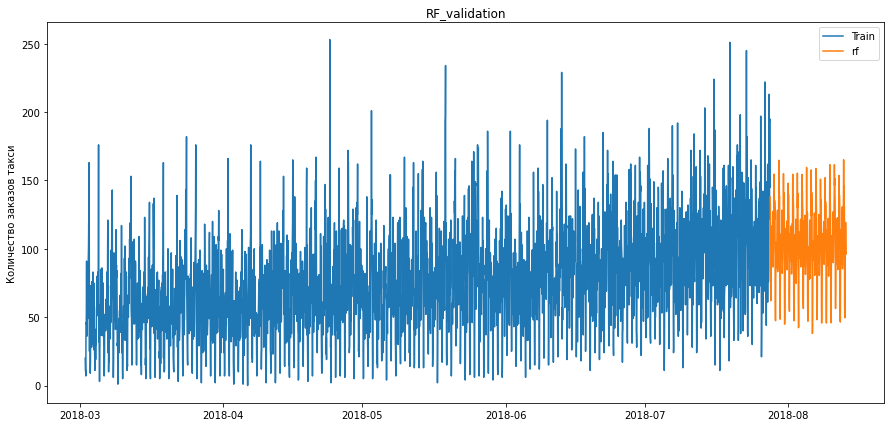

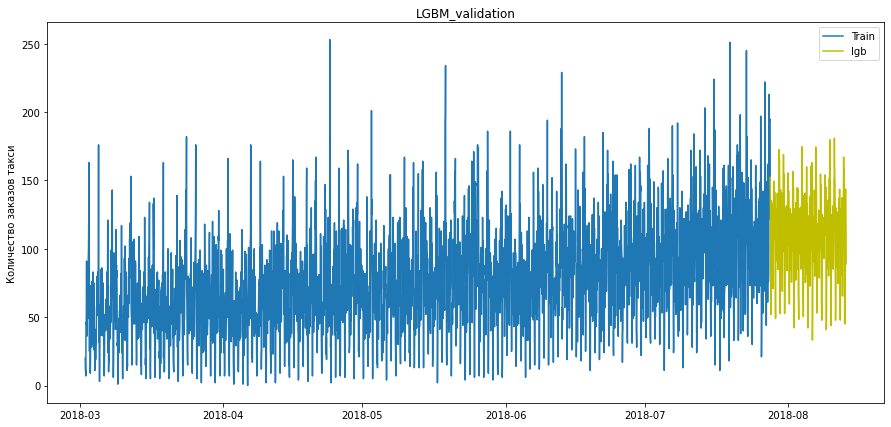

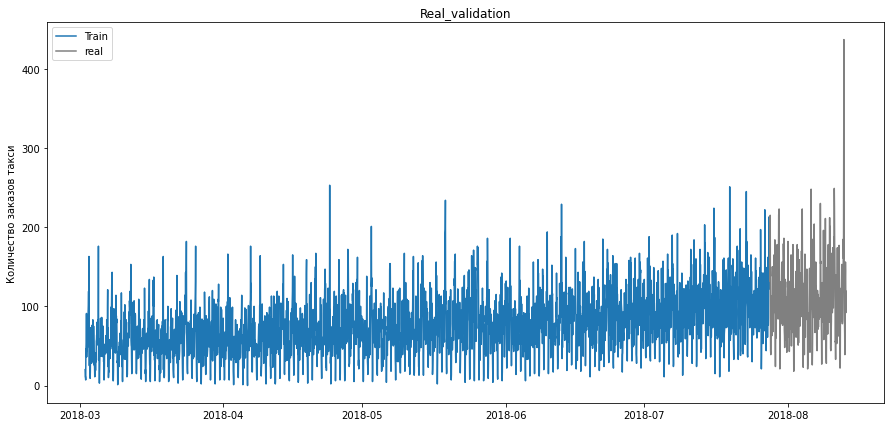

In [28]:
fig, ax = plt.subplots()
ax.plot(train_val.index, train_val['num_orders'], label='Train')
ax.plot(validation.index,  best_preds , label='rf')
ax.legend()
plt.title('RF_validation')
plt.ylabel("Количество заказов такси")
plt.show()

fig, ax = plt.subplots()
ax.plot(train_val.index, train_val['num_orders'], label='Train')
ax.plot(validation.index,  best_preds_lgb , label='lgb', color='y')
ax.legend()
plt.title('LGBM_validation')
plt.ylabel("Количество заказов такси")
plt.show()

fig, ax = plt.subplots()
ax.plot(train_val.index, train_val['num_orders'], label='Train')
ax.plot(validation.index,  validation['num_orders'] , label='real', color='grey')
ax.legend()
plt.title('Real_validation')
plt.ylabel("Количество заказов такси")
plt.show()

In [29]:
# Создаем модель экспоненциального сглаживания
fit1 = SimpleExpSmoothing(train_val[target], initialization_method="heuristic").fit(
    smoothing_level=0.8, optimized=False
)
forecast = fit1.forecast(len(validation)).rename(r"$\alpha=0.2$")
df_score['Simple Exp Smoothing']['best_score_validation'] = mean_squared_error(validation['num_orders'],forecast, squared=False)

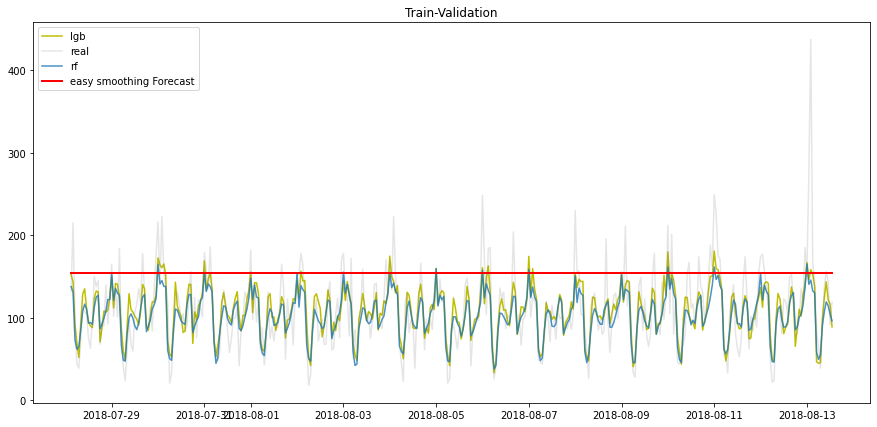

In [30]:
fig, ax = plt.subplots()
ax.plot(validation.index,  best_preds_lgb , label='lgb', color='y')

ax.plot(validation.index,  validation['num_orders'] , label='real', color='grey',alpha=0.2)
ax.plot(validation.index,  best_preds , label='rf',alpha=0.8)
ax.plot(forecast.index, forecast, label='easy smoothing Forecast', color = 'r',linewidth=2)
ax.legend()
plt.title('Train-Validation')
plt.show()

In [31]:
df_score

,LGBM,Random Forest,Simple Exp Smoothing
best_score_validation,30.34502,31.261915,64.187423
score_test,NaN,NaN,NaN


<div style='background-color: #f2f2f2; padding: 10px; border: 3px solid #ccc; border-radius: 10px;'>
    <p><strong>Промежуточный вывод:</strong>   <br>
• LGBM показал лучшие результаты, чем Random Forest и Simple Exp Smoothing. Модель LGBM имеет меньшую ошибку предсказания (30.34), чем модель Random Forest (31.26) и гораздо меньшую ошибку, чем модель Simple Exp Smoothing (64.19).<br><br>
• Random Forest также демонстрирует хорошие результаты, но несколько хуже, чем LGBM. Ошибка Random Forest составляет 8.711205, что на 1.1% больше, чем ошибка LGBM.   <br><br>
• Были подобраны лучшие гиперпараметры<br>
    </p>
</div>

## Тестирование

In [32]:
train = pd.DataFrame(train)
test = pd.DataFrame(test)

df_to_concat = pd.concat([train,test], axis=0)
df_to_concat = add_features(df_to_concat)

train,test = df_to_concat.iloc[0:int(0.9*len(df_to_concat)),:], df_to_concat.iloc[int(0.9*len(df_to_concat)):len(df_to_concat),:]

train = add_features(train)
test = add_features(test)

In [33]:
best_model.fit(train[features], train[target].values)
pr_rf = best_model.predict(test[features])

best_model_lgb.fit(train[features], train[target].values)
pr_lgb = best_model_lgb.predict(test[features])

[LightGBM] [Warning] Unknown parameter: njobs
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=5, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=5
[LightGBM] [Warning] lambda_l2 is set=0.2, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2


In [34]:
fit1 = SimpleExpSmoothing(train[target], initialization_method="heuristic").fit(
    smoothing_level=0.8, optimized=False
)
forecast = fit1.forecast(len(test)).rename(r"$\alpha=0.2$")


In [35]:
#df_score['Random Forest']['score_test'] = mean_squared_error(test[target],pr_rf,squared=False)
df_score['LGBM']['score_test'] = mean_squared_error(test[target],pr_lgb,squared=False)
#df_score['Simple Exp Smoothing']['score_test'] = mean_squared_error(test[target],forecast,squared=False)

In [36]:
df_score

,LGBM,Random Forest,Simple Exp Smoothing
best_score_validation,30.345020,31.261915,64.187423
score_test,40.026465,NaN,NaN


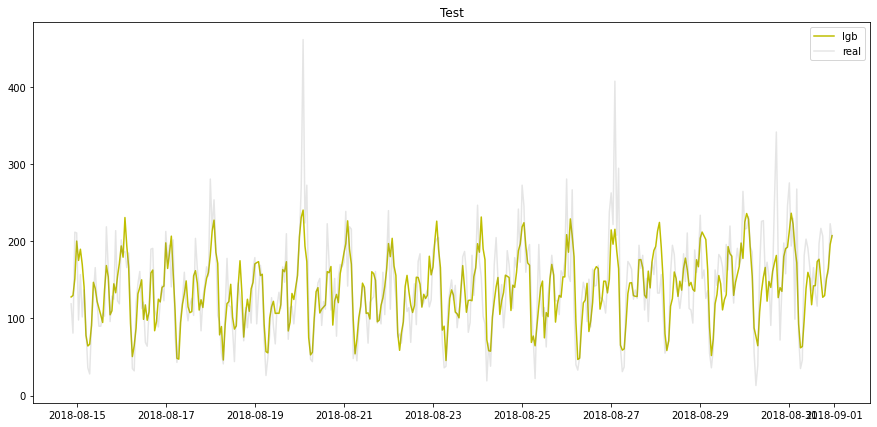

In [37]:
fig, ax = plt.subplots()
ax.plot(test.index,  pr_lgb , label='lgb', color='y')

ax.plot(test.index,  test['num_orders'] , label='real', color='grey',alpha=0.2)
#ax.plot(test.index,  pr_rf , label='rf',alpha=0.8)
#ax.plot(test.index, forecast, label='easy smoothing Forecast', color = 'r',linewidth=2)
ax.legend()
plt.title('Test')
plt.show()

<div style='background-color: #f2f2f2; padding: 10px; border: 3px solid #ccc; border-radius: 10px;'>
    <p><strong>Промежуточный вывод:</strong>   <br><br>
• LGBM показал качество 40.26 - оно укладывается в заданную погрешность.    <br><br>
    </p>
</div>